In [50]:
import os.path

import numpy as np
from os.path import join
import matplotlib.pyplot as plt
import pandas as pd
import umap
from tqdm import tqdm
from hipposlam.VAE import ContrastiveEmbeddingDataloader, VAELearner
import torch
from torch.utils.data import DataLoader
import pickle

In [51]:
class OfflineEmbeddingLearner:
    def __init__(self, lowSThresh):

        self.lowSThresh = lowSThresh
        self.sid2embed = []

    def observe(self, e_new, emins, emaxs):
        # Initial condition
        if len(self.sid2embed) == 0:
            self.sid2embed.append(e_new.copy())
            return len(self.sid2embed) - 1, 0

        e_mat = np.stack(self.sid2embed)  # -> (Nstates, Embed_dim)

        # # Cosine similarity. (Embed_dim, ) @ (Nstates, Embed_dim).T -> (Nstates, )
        # cossim = e_new @ (e_mat.T) / (np.linalg.norm(e_new) * np.linalg.norm(e_mat, axis=-1) + 1e-9)
        # sim_measure = cossim
        sim_measure = self.prenorm_eudist(e_new, e_mat, emins, emaxs)
        maxid = np.argmax(sim_measure)
        maxcossim = sim_measure[maxid]

        if (maxcossim < self.lowSThresh):  # Not matching any existing embeddings
            # Create a new state, and remember the embedding
            self.sid2embed.append(e_new.copy())
            return len(self.sid2embed) - 1, 1

        else:
            return maxid, maxcossim


    def prenorm_eudist(self, e_new, e_mat, emins, emaxs):

        e_new = (e_new - emins) / (emaxs - emins)
        e_mat = (e_mat - emins) / (emaxs - emins)
        eusim = 1 - np.sqrt(np.sum(np.square(e_new.reshape(1, -1) - e_mat), axis=1))/np.sqrt(2)
        return eusim

In [52]:
# Load data
project_dir = join('data', 'VAE')
load_embed_dir = join(project_dir, 'embeds2')
load_annotation_pth = join(project_dir, 'annotations2.csv')
save_dir = join(project_dir, 'model', 'OnlyEmbed')

dataset = ContrastiveEmbeddingDataloader(load_annotation_pth, load_embed_dir, batchsize=64, datainds=[0, 10032])


In [55]:
from hipposlam.VAE import ContrastiveVAELearner

# VAE
con_mul = 1.0
load_ckpt_pth = 'data/VAE/model/ContrastiveVAEmul=1.0000/ckpt_ContrastiveVAEmul=1.0000_cycle9.pt'
vaelearner = ContrastiveVAELearner(
    input_dim=576,
    hidden_dims=[400, 200, 100, 50, 25],
    con_margin=0.1,
    con_mul=con_mul,
    lr=0.001,
    lr_gamma=0.98,
    weight_decay=0
)
vaelearner.load_checkpoint(load_ckpt_pth)
vaelearner.vae.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=576, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=400, out_features=200, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=200, out_features=100, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=100, out_features=50, bias=True)
  )
  (bottleneck_mu): Sequential(
    (0): Linear(in_features=50, out_features=25, bias=True)
  )
  (bottleneck_logvar): Sequential(
    (0): Linear(in_features=50, out_features=25, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): B

In [56]:
# Inference
muall = []
for i in range(len(dataset)):

    xinput = dataset.embed_all[[i], :]
    _, _, (_, mu, _) = vaelearner.infer(xinput, 1)
    muall.append(mu)
muall = torch.vstack(muall)
muall = muall.numpy()


In [60]:
# labels
labels = dataset.labels_xya

In [66]:
umins = muall.min(axis=0)
umaxs = muall.max(axis=0)
lowSThresh = 0.5
oel = OfflineEmbeddingLearner(lowSThresh)
Niters = 10000
sid = np.zeros(Niters)
sval = np.zeros(Niters)
obsnum = np.zeros(Niters)
for i in tqdm(range(Niters)):
    sid[i], sval[i] = oel.observe(muall[i, :], umins, umaxs)
    obsnum[i] = len(oel.sid2embed)




100%|██████████| 10000/10000 [00:02<00:00, 4037.37it/s]


Number of unique states = 260


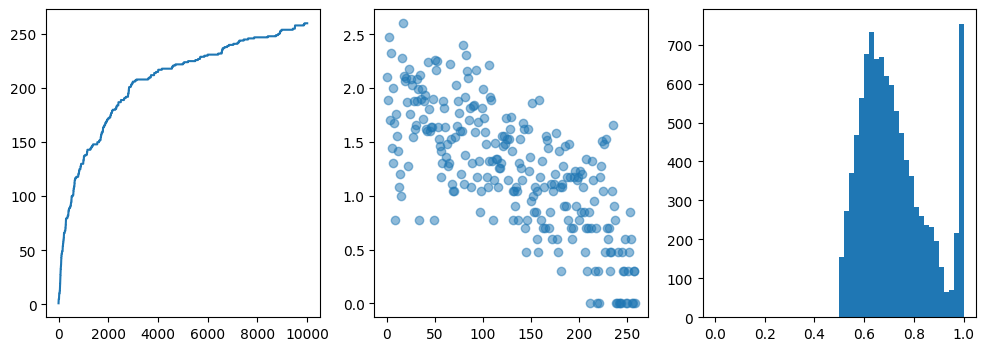

In [67]:
unique_sids, unique_counts = np.unique(sid, return_counts=True)
print('Number of unique states = %d'%(unique_sids.shape[0]))
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(obsnum)
ax[1].scatter(unique_sids, np.log10(unique_counts), alpha=0.5)
_ = ax[2].hist(sval, bins=50)

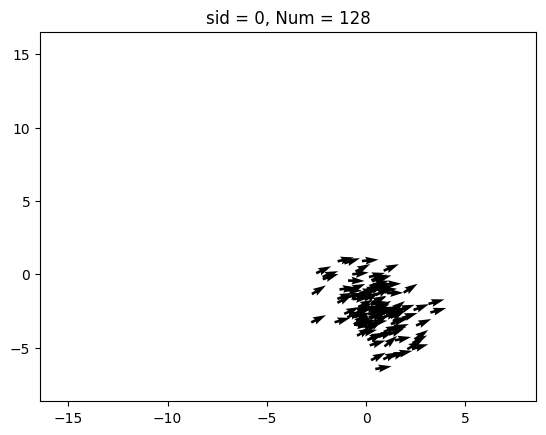

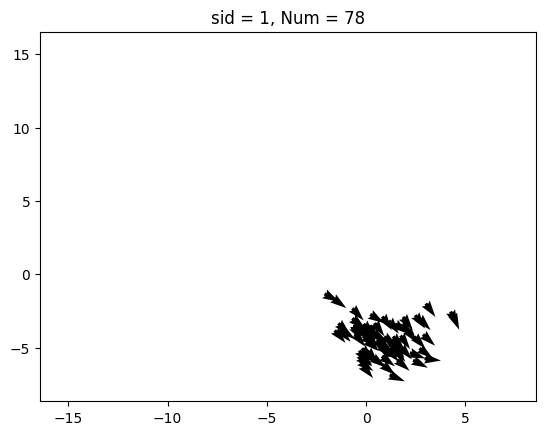

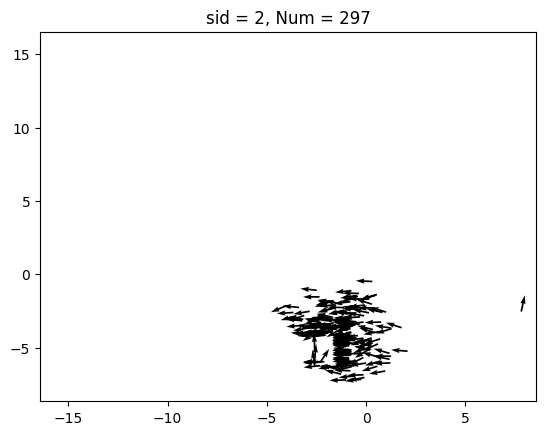

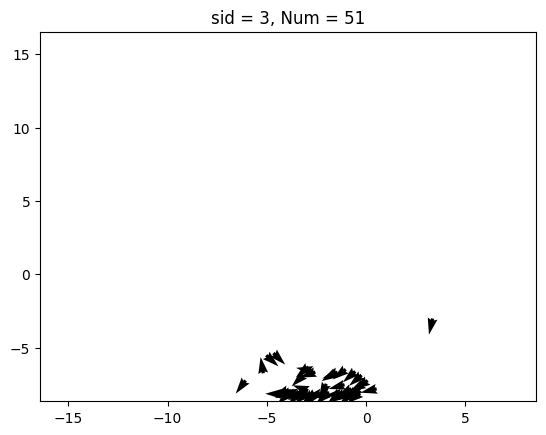

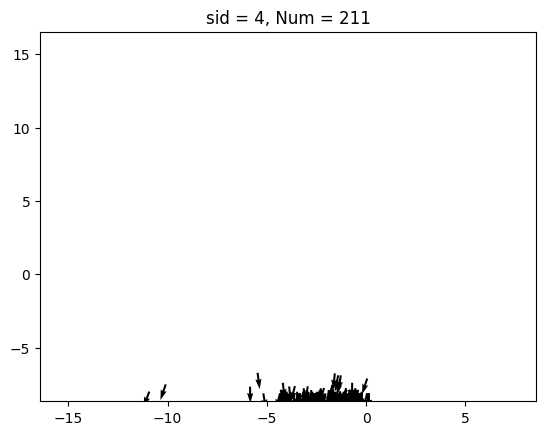

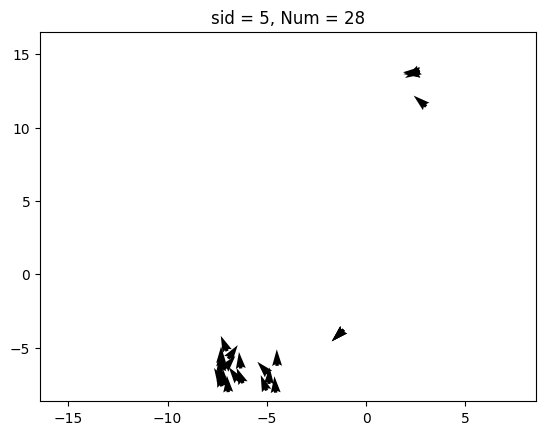

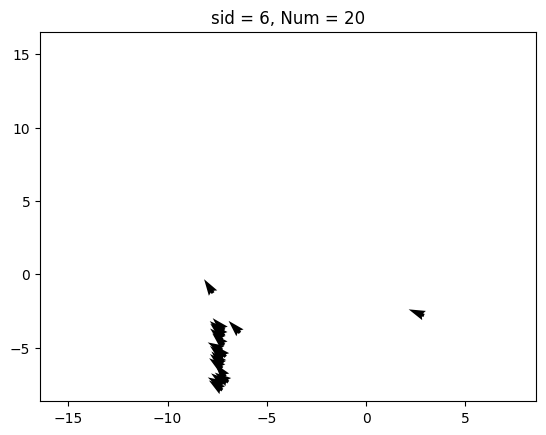

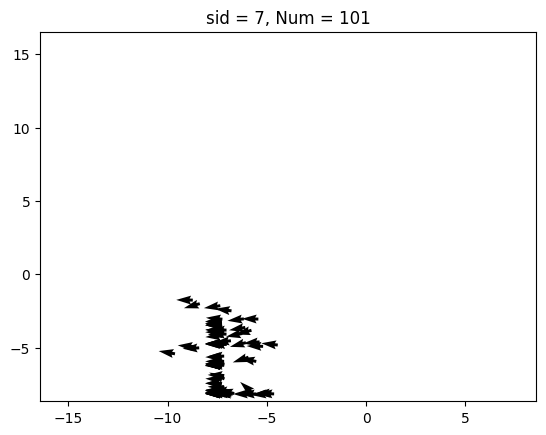

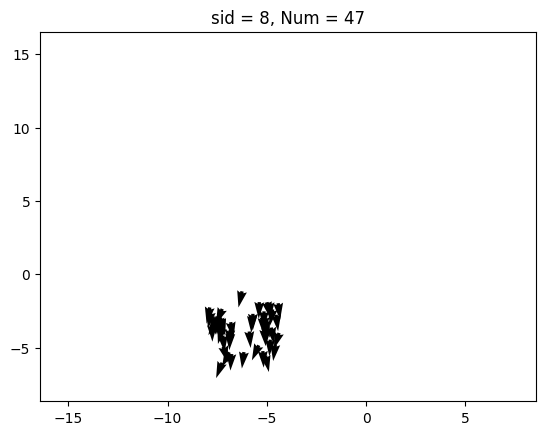

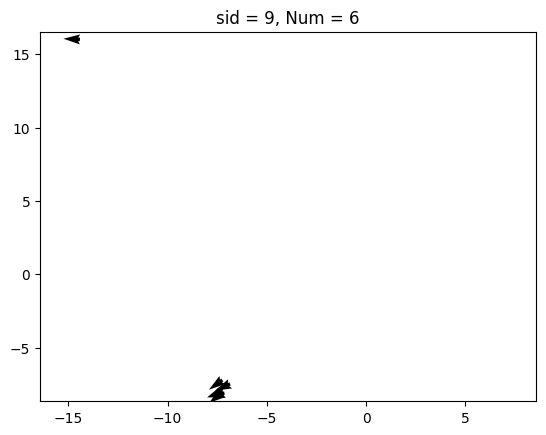

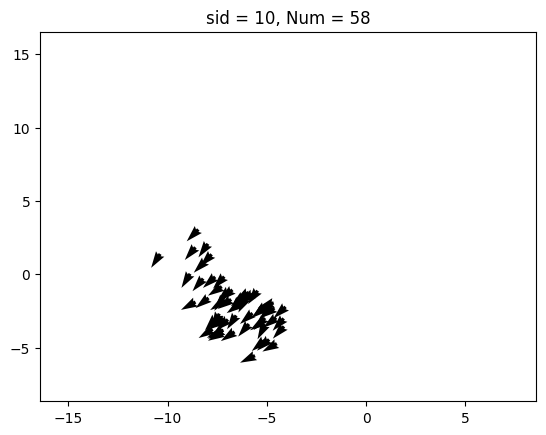

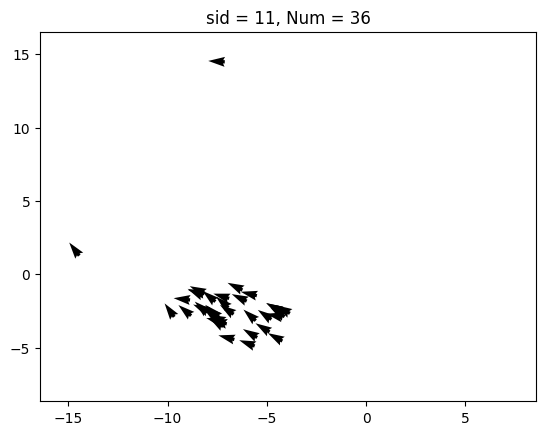

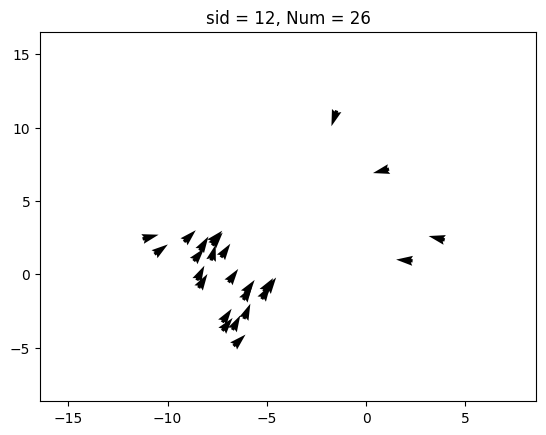

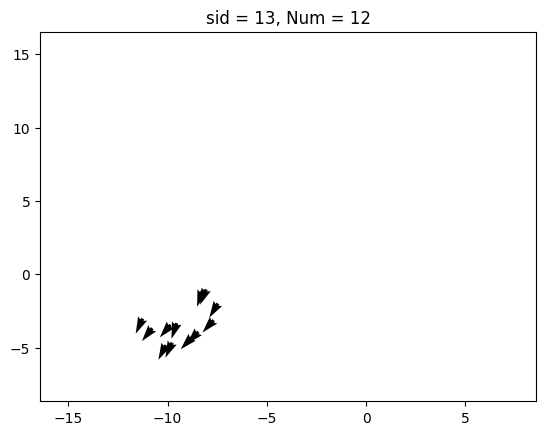

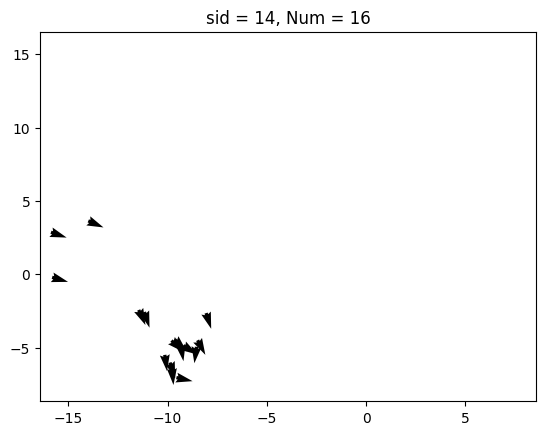

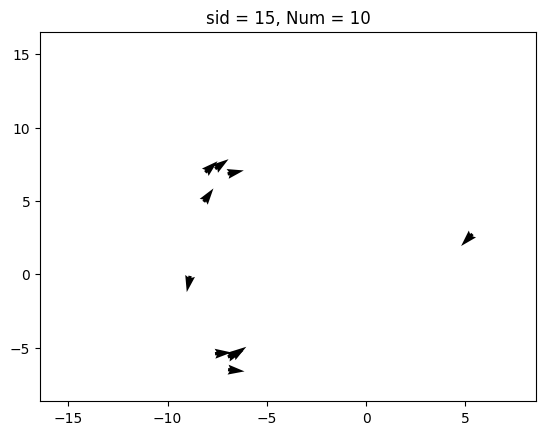

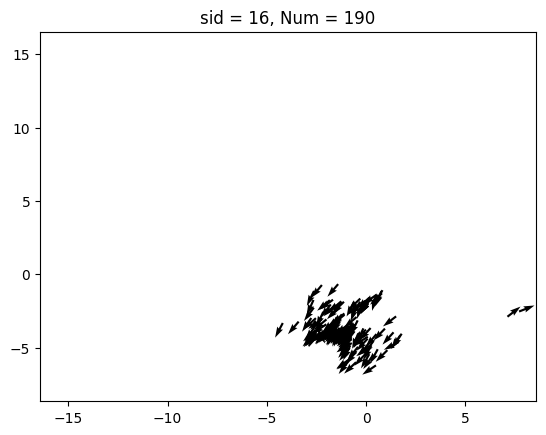

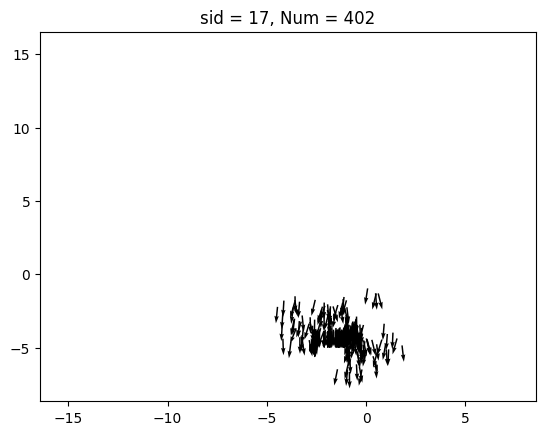

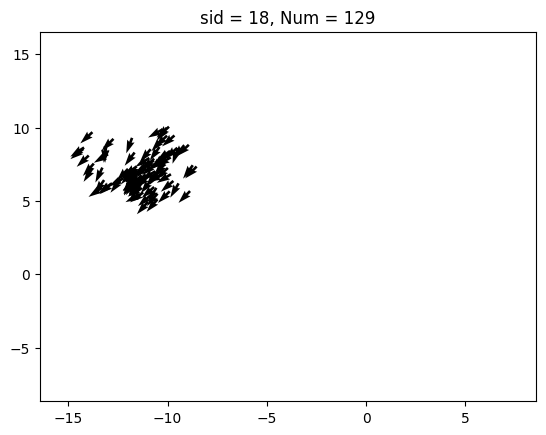

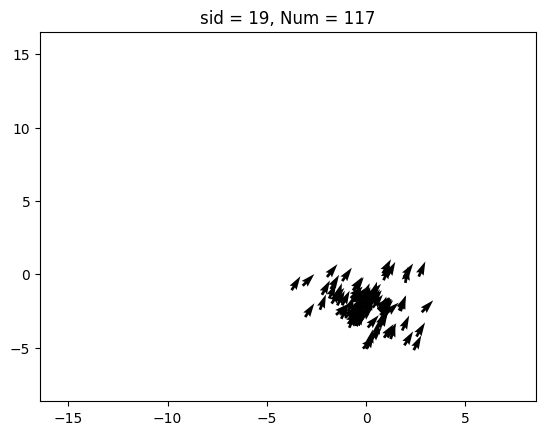

In [68]:
x, y, a = labels[:Niters, 0], labels[:Niters, 1], labels[:Niters, 2]

xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

unique_sids = np.unique(sid)
np.random.seed(10)

selected_sids = np.random.choice(len(unique_sids), 20, replace=False)
# for sid_each in np.append(selected_sids, 0):

for sid_each in np.arange(0, 20):
    mask = sid == sid_each
    xplot = x[mask]
    yplot = y[mask]
    aplot = a[mask]
    fig, ax = plt.subplots()
    ax.quiver(xplot, yplot, np.cos(aplot), np.sin(aplot), scale=30)
    ax.set_xlim(xmin- 0.5, xmax + 0.5)
    ax.set_ylim(ymin- 0.5, ymax + 0.5)
    ax.set_title('sid = %d, Num = %d'%(sid_each, mask.sum()))





In [3]:
class OfflineEmbeddingLearner:
    def __init__(self, lowSThresh):

        self.lowSThresh = lowSThresh
        self.sid2embed = []

    def observe(self, e_new):
        # Initial condition
        if len(self.sid2embed) == 0:
            self.sid2embed.append(e_new.copy())
            return len(self.sid2embed) - 1, 0

        e_mat = np.stack(self.sid2embed)  # -> (Nstates, Embed_dim)

        # Cosine similarity. (Embed_dim, ) @ (Nstates, Embed_dim).T -> (Nstates, )
        cossim = e_new @ (e_mat.T) / (np.linalg.norm(e_new) * np.linalg.norm(e_mat, axis=-1) + 1e-9)
        sim_measure = cossim

        # e_new_norm = e_new / np.linalg.norm(e_new)
        # e_mat_norm = e_mat / np.linalg.norm(e_mat, axis=-1).reshape(-1, 1)
        # eudist = 1 - np.sqrt(np.sum(np.square(e_new_norm.reshape(1, -1) - e_mat_norm), axis=1))
        # sim_measure = eudist

        maxid = np.argmax(sim_measure)
        maxcossim = sim_measure[maxid]

        if (maxcossim < self.lowSThresh):  # Not matching any existing embeddings
            # Create a new state, and remember the embedding
            self.sid2embed.append(e_new.copy())
            return len(self.sid2embed) - 1, 1

        else:
            return maxid, maxcossim

In [4]:
vaelearner = VAELearner(
            input_dim=576,
            hidden_dims=[400, 200, 100, 50, 25],
            kld_mul=0.01,
            lr=0.001,
            lr_gamma=0.95,
            weight_decay=0
        )

model_tag = 'Annealing_bottle25'
ckpt_name = 'ckpt_Annealing_bottle25_cycle9.pt'
load_ckpt_pth = join('data', 'VAE', 'model', model_tag, ckpt_name)
load_loss_pth = join('data', 'VAE', 'model', model_tag, 'loss.csv')
# vaelearner.load_checkpoint('data\VAE\model\kldmul=0.010000_bottle25\ckpt_kldmul=0.010000_bottle25.pt')

vaelearner.load_checkpoint(load_ckpt_pth)
_ = vaelearner.vae.eval()


In [6]:
mu = []
for i in tqdm(range(len(dataset))):
    e_new, label = dataset[i]
    with torch.no_grad():
        _, mutmp, _ = vaelearner.vae(e_new.unsqueeze(0))
    mutmp = mutmp.squeeze().detach().numpy().copy()
    mu.append(mutmp)
mu = np.stack(mu)

  0%|          | 0/10032 [00:00<?, ?it/s]C:\Users\Hoi\projects\HippoSLAM\controllers\hipposlam\hipposlam\trainVAE.py:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(self.img_labels.iloc[idx, [1, 2, 3]], dtype=torch.float32)
100%|██████████| 10032/10032 [00:13<00:00, 736.67it/s]


In [10]:
lowSThresh = 0.8
oel = OfflineEmbeddingLearner(lowSThresh=lowSThresh)
Niters = 10000
sid = np.zeros(Niters)
sval = np.zeros(Niters)
obsnum = np.zeros(Niters)
for i in tqdm(range(Niters)):
    sid[i], sval[i] = oel.observe(mu[i, :])
    obsnum[i] = len(oel.sid2embed)


100%|██████████| 10000/10000 [00:08<00:00, 1172.06it/s]


Number of unique states = 598


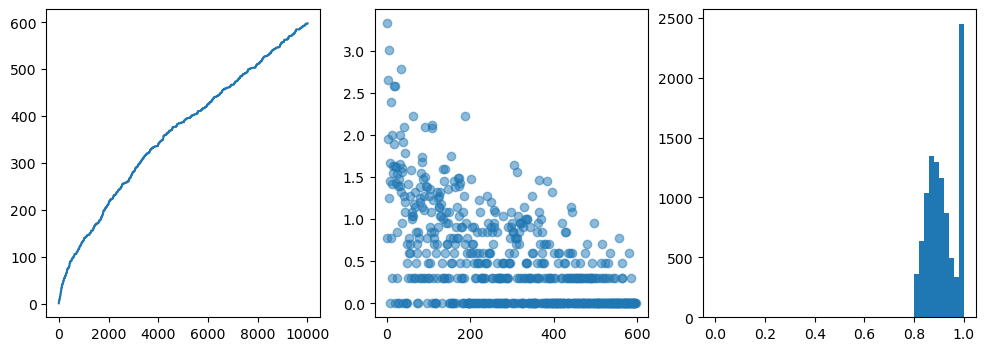

In [11]:
unique_sids, unique_counts = np.unique(sid, return_counts=True)
print('Number of unique states = %d'%(unique_sids.shape[0]))
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(obsnum)
ax[1].scatter(unique_sids, np.log10(unique_counts), alpha=0.5)
_ = ax[2].hist(sval, bins=50)

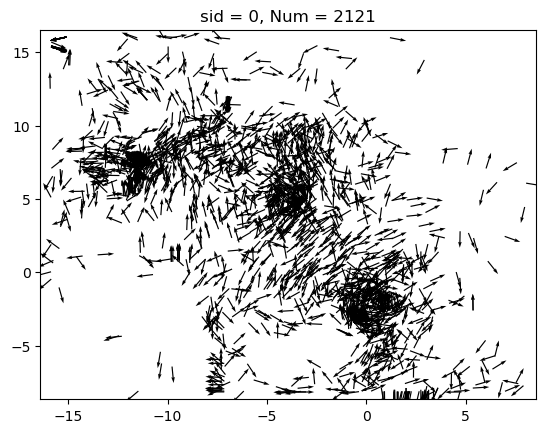

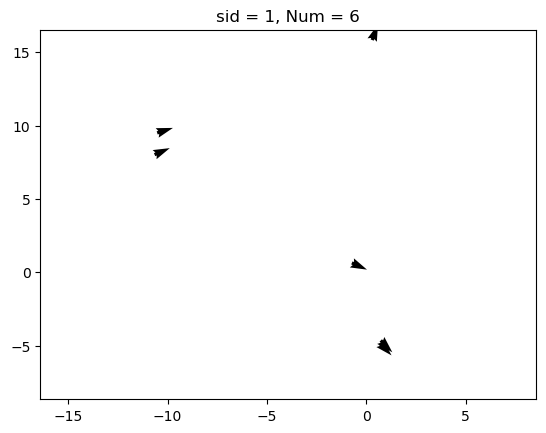

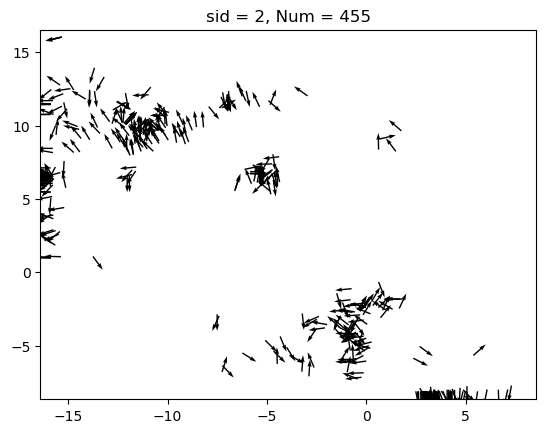

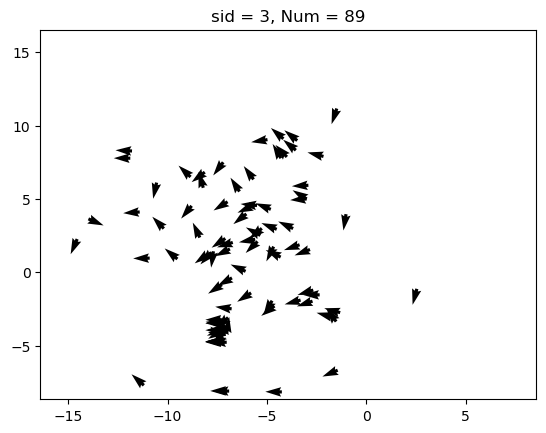

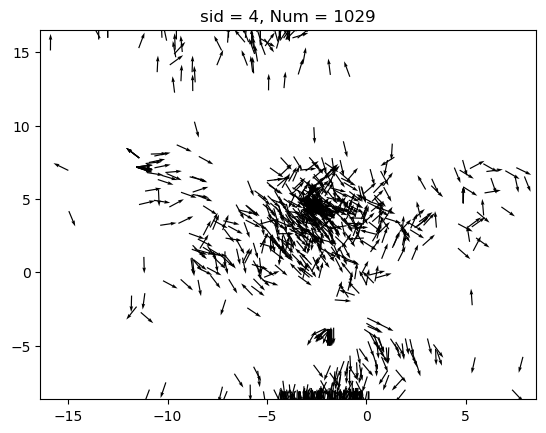

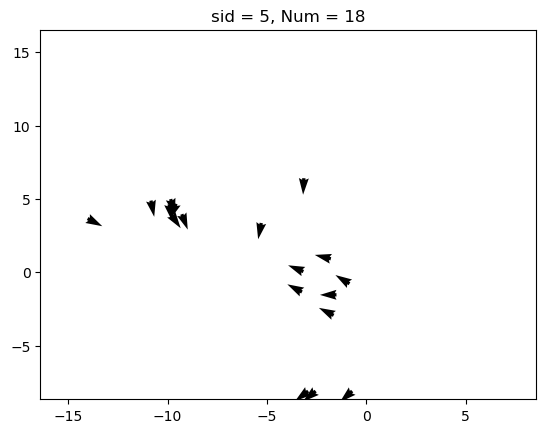

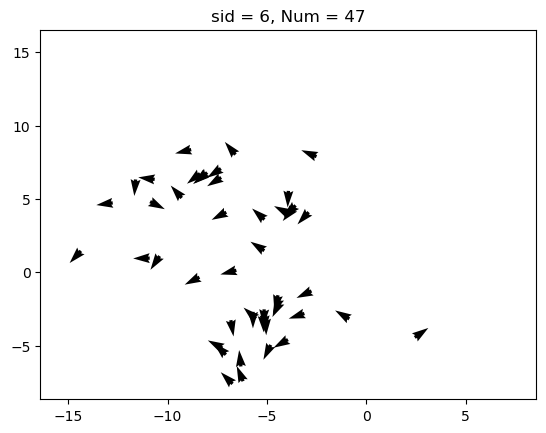

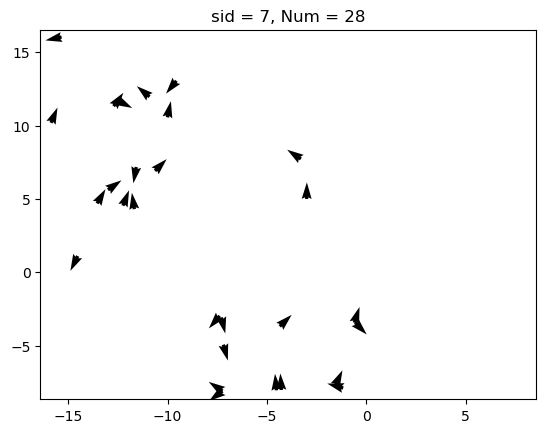

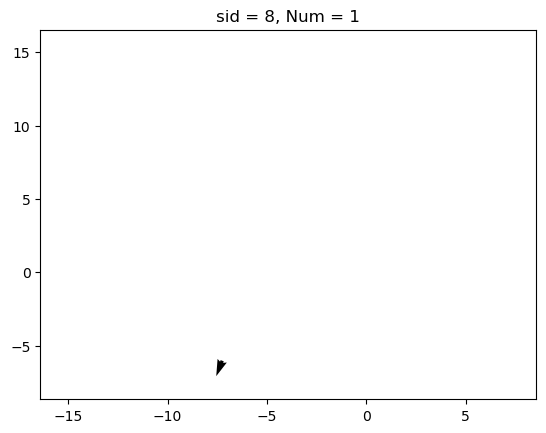

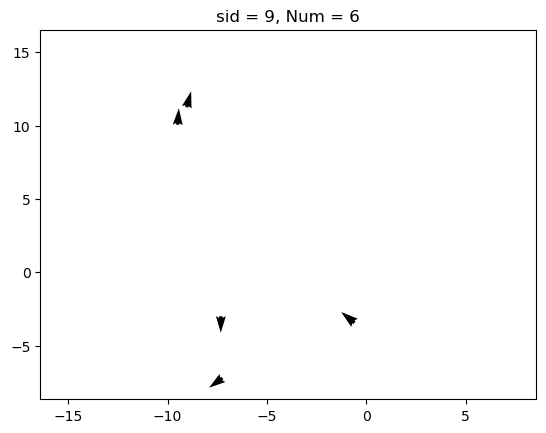

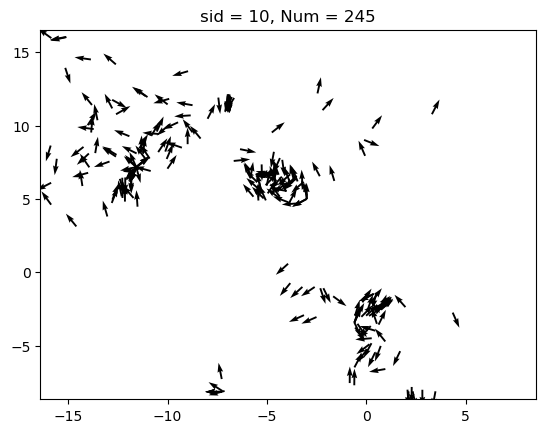

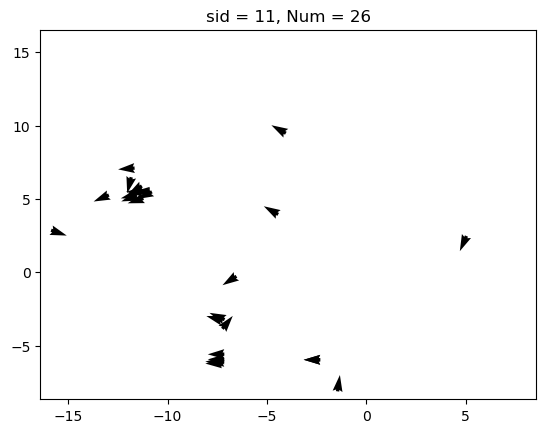

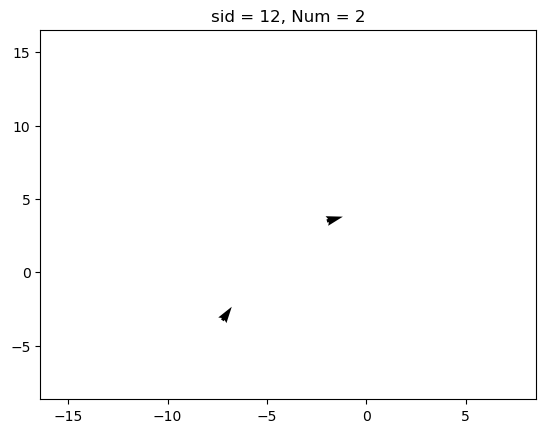

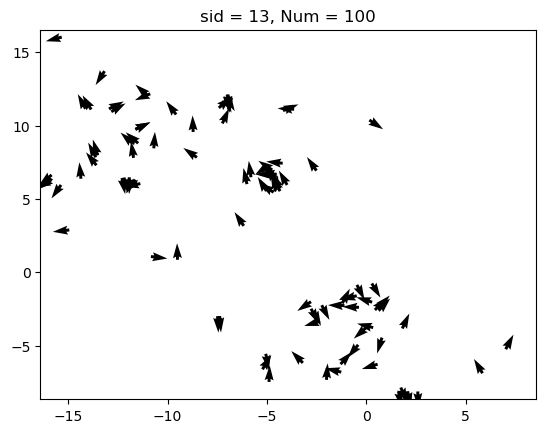

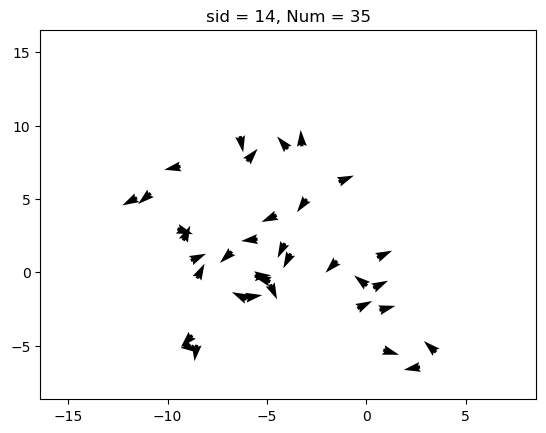

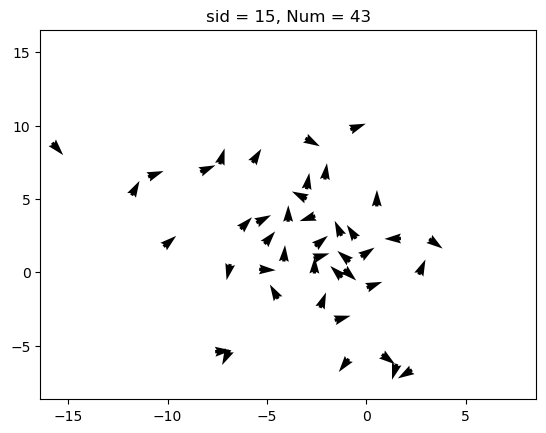

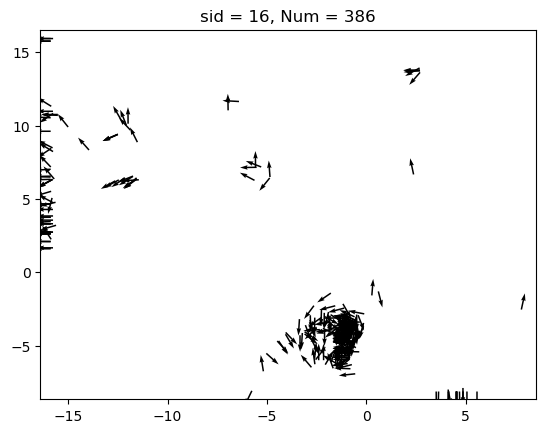

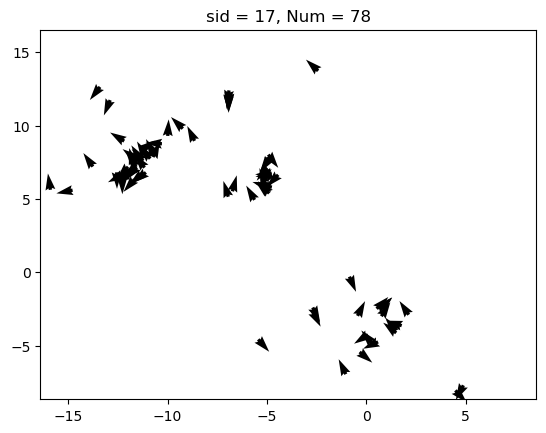

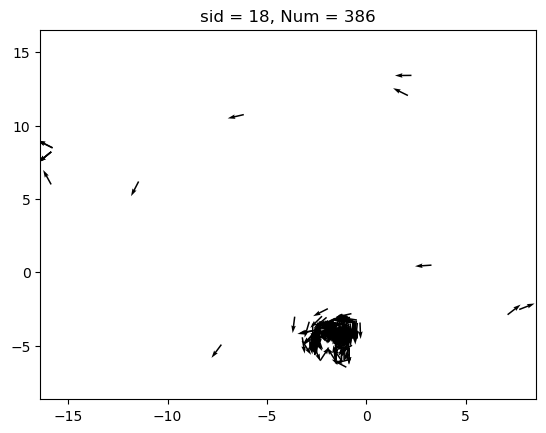

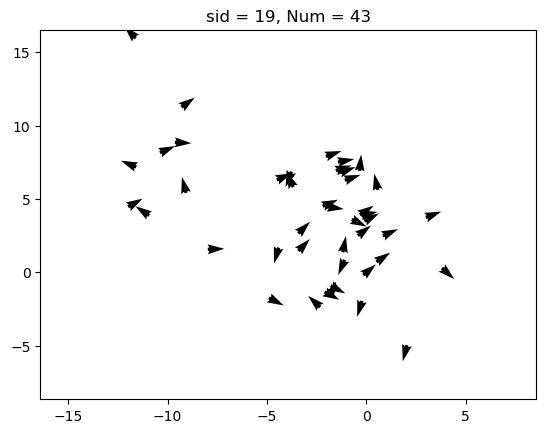

In [12]:
labels = dataset.img_labels.iloc[:Niters, [1, 2, 3]].to_numpy()
x, y, a = labels[:Niters, 0], labels[:Niters, 1], labels[:Niters, 2]

xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

unique_sids = np.unique(sid)
np.random.seed(10)

selected_sids = np.random.choice(len(unique_sids), 20, replace=False)
# for sid_each in np.append(selected_sids, 0):

for sid_each in np.arange(0, 20):
    mask = sid == sid_each
    xplot = x[mask]
    yplot = y[mask]
    aplot = a[mask]
    fig, ax = plt.subplots()
    ax.quiver(xplot, yplot, np.cos(aplot), np.sin(aplot), scale=30)
    ax.set_xlim(xmin- 0.5, xmax + 0.5)
    ax.set_ylim(ymin- 0.5, ymax + 0.5)
    ax.set_title('sid = %d, Num = %d'%(sid_each, mask.sum()))



